In [5]:
import matplotlib.pyplot as plt 
from misc import *
import tensorflow as tf
from tqdm import tqdm
import os 

from tensorflow.python.training.tracking.data_structures import NoDependency
from tensorflow.python.framework.tensor_shape import TensorShape
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
def generate_traj(ppp=4000, periods = 5, itraj=0, path = "/home/cooper-cooper/continous/"):
    #define parameters
    print("gneerating trajectory")
    gamma = 1 #damping from outside
    Gamma = 1 #measurement rate
    eta = 1 # measurement efficiency
    n = 2 # number of photons?
    w = 1
    T = 2*np.pi/w

    C = np.array([[np.sqrt(4*eta*Gamma), 0] ,[0, np.sqrt(4*eta*Gamma)]])

    A = np.array([
        [0., w],
        [-w, 0.]])

    D = np.array([[gamma*(n + 0.5) + Gamma, 0], [0,gamma*(n + 0.5) + Gamma]])

    su = n + 0.5 + Gamma/gamma
    cov_in = np.array([[np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma), 0],
                       [0,np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]])

    dt = T/ppp
    total_points = int(T*periods/dt)

    xi = lambda cov: np.dot(cov, ct(C)) #+ ct(Gamma_matrix)

    signals = []
    covs = [cov_in]
    means = [np.array([1.,0.])] ## initial condition
    xicovs = [xi(covs[-1])]

    for k in tqdm(range(total_points)):
        x = means[-1]
        cov = covs[-1]
        XiCov = xicovs[-1]

        ##deterministic (just to check)
        #dy = np.dot(C, x )*dt
        dy = np.dot(C, x + np.dot(np.linalg.pinv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
        signals.append(dy)

        dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
        dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update

        covs.append(covs[-1] + dcov)
        means.append(means[-1] + dx)
        xicovs.append(xi(covs[-1]))

    means = np.array(means)
    covs = np.array(covs)
    xicovs = np.array(xicovs)
    signals = np.array(signals)
    coeffs = [C, A, D , dt]
    return means, covs, xicovs, signals, coeffs

In [131]:
class Rcell(tf.keras.layers.Layer):
    def __init__(self,state_size, coeffs=None):
        self.state_size = state_size   ## Favorite: state_size = NoDependency([2, TensorShape([2,2])])
        super(Rcell, self).__init__()
        self.C, self.dt = coeffs

    def build(self, input_shape):
        self.coeffs_A = self.add_weight(shape=(2, 2),
                                      initializer='uniform',
                                      name='kernel')

        self.built = True


    def call(self, inputs, states):
        dy = inputs
        sts, covs = states
        
        output = tf.einsum('ij,bj->bi',self.C, sts)*self.dt
        
        xicov = tf.einsum('bij,jk->bik',covs,ct(self.C))
        A_minus_xiC = self.coeffs_A - tf.einsum('bij,jk->bik',xicov,self.C)
        
        dx = tf.einsum('bij,bj->bi',A_minus_xiC, sts)*self.dt + tf.einsum('bij,bj->bi', xicov, dy)
        x = sts + dx

        ctxicov = tf.stack([ct(kk) for kk in tf.unstack(xicov)], axis=0)
        cov_dt = tf.einsum('bij,jk->bik',covs, self.coeffs_A) + tf.einsum('ij,bjk->bik',self.coeffs_A,covs) -tf.einsum('bij,bjk->bik',xicov, ctxicov)
        new_cov = cov + cov_dt*self.dt
    
        new_states = [x, tf.clip_by_value(new_cov, -1,1)]
        return output, [new_states]


In [177]:
def give_presicion(preds, expected_output):
    return np.max(np.abs(preds[0][:,0] - np.array(expected_output[:,0][:-1]).astype(np.float32)))


precisions = []
PPPs=[10, 100, 500, 1000, 2000, 4000, 6000]
for pp in PPPs:
    
    path = "/home/cooper-cooper/continuous/sanity/integration"
    os.makedirs(path, exist_ok=True)
    means, covs, xicovs, signals, coeffs = generate_traj(ppp=pp)

    tfsignals = tf.convert_to_tensor(signals.astype(np.float32))
    tfmeans = tf.convert_to_tensor(means)

    state_size = NoDependency([2, TensorShape([2,2])])
    recurrent_layer = tf.keras.layers.RNN([Rcell(state_size, coeffs=[C, dt])], return_sequences=True, stateful=False)

    x0 = tf.convert_to_tensor(np.array([[1,0]]).astype(np.float32))
    Sig0 = tf.convert_to_tensor(cov_in.astype(np.float32))

    #call once so initialize and fix good parameters
    recurrent_layer(tfsignals[tf.newaxis,:1], initial_state = [[x0 , tf.eye(2)[tf.newaxis]]]) 
    recurrent_layer.trainable_variables[0].assign(tf.convert_to_tensor(A.astype(np.float32)))

    expected_output = tf.einsum('ij,bj->bi',C, tfmeans)*dt
    preds = recurrent_layer(tfsignals[tf.newaxis], initial_state=[[x0, Sig0[tf.newaxis]]])

    precisions.append(give_presicion(preds, expected_output))
    np.save(path+"/preds_{}".format(pp), preds)
    np.save(path+"/ground_{}".format(pp), expected_output)
    np.save(path+"/precision",np.array(precisions))

100%|██████████| 30000/30000 [00:03<00:00, 8637.81it/s]


First Check: what happens if the coefficients of A are actually the correct ones ?

In [169]:
PPPs=[100, 500, 1000, 2000, 4000, 10000]

Text(0.5, 0, 'Points per period \n(total 5 periods)')

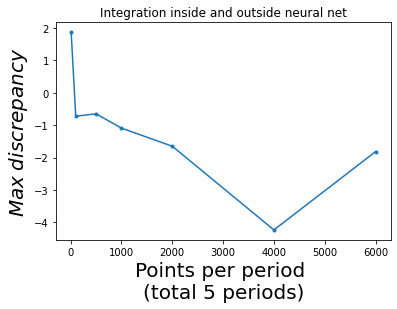

In [180]:
plt.title("Integration inside and outside neural net")
plt.plot(PPPs,np.log10(precisions),'.-')
plt.ylabel(r'$Max \; discrepancy$',size=20)
plt.xlabel("Points per period \n(total 5 periods)", size=20)

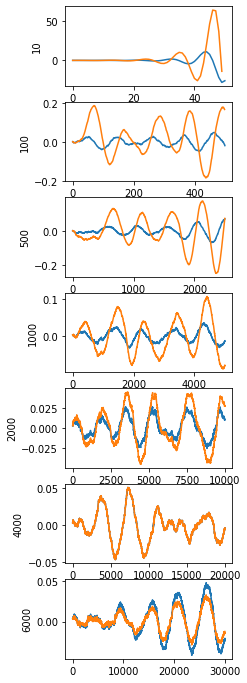

In [196]:
plt.figure(figsize=(3,12))
for i,pp in enumerate(PPPs):
    preds = np.load(path+"/preds_{}.npy".format(pp))
    expected_output = np.load(path+"/ground_{}.npy".format(pp))
    ax = plt.subplot2grid((len(PPPs),1),(i,0))
    ax.plot(np.array(expected_output[:,0]).astype(np.float32))
    ax.plot(preds[0][:,0])
    ax.set_ylabel(str(pp))

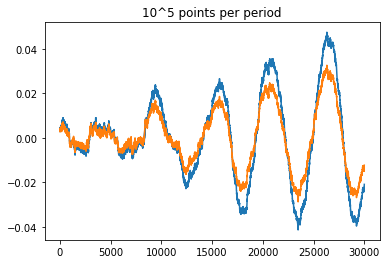

In [181]:
plt.title("10^5 points per period")


In [22]:
class Rcell(tf.keras.layers.Layer):
    def __init__(self,state_size, coeffs=None):
        self.state_size = tuple([2,4])#,tf.TensorShape([2,2,1]) )#[(2,2), (1,2)]
        super(Rcell, self).__init__()
        self.C, self.dt = coeffs

    def build(self, input_shape):
        self.coeffs_A = self.add_weight(shape=(2, 2),
                                      initializer='uniform',
                                      name='kernel')

        self.built = True


    def call(self, inputs, states):
        dy = inputs
        sts, covs = states
        
        xicov = tf.einsum('bij,jk->bik',covs,ct(self.C))
        A_minus_xiC = self.coeffs_A - tf.einsum('bij,jk->bik',xicov,self.C)
        
        dx = tf.einsum('bij,bj->bi',A_minus_xiC, sts)*self.dt + tf.einsum('bij,bj->bi', xicov, dy)
        x = sts + dx
        output = tf.einsum('ij,bj->bi',self.C, sts)*self.dt

        ctxicov = tf.stack([ct(kk) for kk in tf.unstack(xicov)], axis=0)
        new_cov = tf.einsum('bij,jk->bik',covs, self.coeffs_A) + tf.einsum('ij,bjk->bik',self.coeffs_A,covs) -tf.einsum('bij,bjk->bik',ctxicov,xicov)
       
        new_states = [x, tf.clip_by_value(new_cov, -10,10)]
        return output, [new_states]

In [23]:
tfsignals = tf.convert_to_tensor(signals)

In [26]:
from romo import *

In [27]:
rro = GaussianRecuModel(coeffs[:-2])

In [33]:
rro.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [34]:
tfsignals = tf.expand_dims(signals,axis=0)

In [35]:
rro.fit(x=tfsignals, y=tf.expand_dims(signals,axis=0))

Tensor("gaussian_recu_model_5/rnn_2/zeros:0", shape=(None, 2), dtype=float32)
Tensor("gaussian_recu_model_5/rnn_2/zeros_1:0", shape=(None, 4), dtype=float32)


ValueError: in user code:

    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/cooper-cooper/continuous/romo.py:92 train_step  *
        preds = self(inputs)
    /home/cooper-cooper/continuous/romo.py:85 call  *
        return self.recurrent_layer(inputs)#, initial_state = self.initial_state)
    /home/cooper-cooper/continuous/romo.py:28 call  *
        A_minus_xiC = self.coeffs_A - tf.einsum('btij,jk->btik',xicov,self.C)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/ops/special_math_ops.py:684 einsum
        return _einsum_v2(equation, *inputs, **kwargs)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/ops/special_math_ops.py:1113 _einsum_v2
        return gen_linalg_ops.einsum(inputs, resolved_equation)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py:1104 einsum
        "Einsum", inputs=inputs, equation=equation, name=name)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 4 but is rank 3
    	 for 0th input and equation: btij,jk->btik for '{{node gaussian_recu_model_5/rnn_2/stacked_rnn_cells_2/rcell_3/einsum_1/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="btij,jk->btik"](gaussian_recu_model_5/rnn_2/stacked_rnn_cells_2/rcell_3/einsum/Einsum, gaussian_recu_model_5/rnn_2/stacked_rnn_cells_2/rcell_3/einsum_1/Einsum/inputs_1)' with input shapes: [1,2,2], [2,2].


In [506]:


initial_A = model.trainable_variables


### training ####
history_A, history_loss = [], []
for time_slice in [-1]:#tqdm(np.linspace(10,len(signals),10).astype(np.int)):
    inputs = sliced_dataset(signals, xicovs,time_slice)
    histo = model.fit(x=inputs, y=inputs[1][tf.newaxis,:,:], epochs=100, verbose=1)
    for k,v in zip(histo.history["Coeffs_A"], histo.history["total_loss"]):
        history_A.append(k)
        history_loss.append(v)


#os.makedirs("/data/uab-giq/scratch/matias/quantera/trajectories/{}/".format(itraj), exist_ok=True)
np.save(path+"{}/A_history".format(itraj),np.array(history_A) )
np.save(path+"{}/loss_history".format(itraj),np.array(history_loss) )

tf.Tensor([[0.07960939 0.35535204]], shape=(1, 2), dtype=float32)
***
(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>)


InvalidArgumentError: Expected input 0 to have rank 3 but got: 4 [Op:Einsum]

(<tf.Tensor: shape=(1, 4, 2), dtype=float32, numpy=
 array([[[0.6531478 , 0.19194245],
         [0.80697405, 0.96950877],
         [0.17117214, 0.3720472 ],
         [0.1436044 , 0.57822907]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
 array([[[0.8903556 , 0.03463471, 0.62126803, 0.8606322 ],
         [0.0857079 , 0.6587448 , 0.3343135 , 0.8601774 ],
         [0.2644328 , 0.41318822, 0.00654733, 0.7604159 ],
         [0.7076229 , 0.1564573 , 0.29632783, 0.8159584 ]]], dtype=float32)>)

## option 1: everything in the same net

In [398]:
class Rcell(tf.keras.layers.Layer):
    def __init__(self,state_size):
        self.state_size = (tf.TensorShape([2,2]), )#[(2,2), (1,2)]
        super(Rcell, self).__init__()

    def build(self, input_shape):
        self.coeffs_A = self.add_weight(shape=(2, 2),
                                      initializer='uniform',
                                      name='kernel')
        
        self.built = True

    def call(self, inputs, states):
        x = inputs
        new_states = states
        output = inputs
        return output, [x]

In [399]:
rcell = Rcell(2)
rlayer = tf.keras.layers.RNN([rcell], return_sequences=True)
dY = tf.random.uniform((1,100,2))


In [400]:
initial_state = tf.convert_to_tensor(np.array([[1,0]]).astype(np.float32))
initial_state = tuple([tf.random.uniform((1,2,2)), tf.random.uniform((1,1,2))])#tuple([tf.random.uniform((2,2))])#, tf.random.uniform((1,2))])

In [401]:
rlayer(tf.random.uniform((1,4,2,2)), initial_state=initial_state)

ValueError: An `initial_state` was passed that is not compatible with `cell.state_size`. Received `state_spec`=ListWrapper([InputSpec(shape=(1, 2, 2), ndim=3), InputSpec(shape=(1, 1, 2), ndim=3)]); however `cell.state_size` is [(TensorShape([2, 2]),)]

In [355]:
InputSpec(shape=(2, 2), ndim=2)

AttributeError: module 'tensorflow' has no attribute 'InputSpec'

In [270]:
rlayer.submodules[0].trainable_variables

[<tf.Variable 'rnn_46/stacked_rnn_cells_46/rcell_42/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.04681015,  0.044087  ],
        [ 0.03547441,  0.0109726 ]], dtype=float32)>]

In [252]:
rlayer(dY)

[<tf.Tensor: shape=(1, 100, 2), dtype=float32, numpy=
 array([[[0.        , 0.        ],
         [0.45785725, 0.19942284],
         [0.06190836, 0.79940295],
         [0.48556364, 0.49459887],
         [0.34573996, 0.7961639 ],
         [0.6642134 , 0.8861517 ],
         [0.3547889 , 0.93633723],
         [0.7156168 , 0.9874871 ],
         [0.5012095 , 0.25257516],
         [0.6304673 , 0.9815842 ],
         [0.23888326, 0.5077789 ],
         [0.3768363 , 0.6022023 ],
         [0.22787118, 0.3325492 ],
         [0.6171118 , 0.9741014 ],
         [0.25555038, 0.9678217 ],
         [0.01758265, 0.32950842],
         [0.27126908, 0.41023815],
         [0.5208206 , 0.59455514],
         [0.3429867 , 0.94237804],
         [0.9723921 , 0.43002152],
         [0.36331356, 0.64204574],
         [0.03184986, 0.6166712 ],
         [0.19523776, 0.3981892 ],
         [0.5341115 , 0.2743038 ],
         [0.23273337, 0.92389905],
         [0.95938134, 0.53013456],
         [0.07370842, 0.3959577 ],
 